In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path (update with your actual path)
dataset_path = "/content/drive/MyDrive/Stenosis detection/arcade"
os.listdir(dataset_path)  # List dataset files


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['stenosis',
 'syntax',
 'weights',
 'weights_CBAM+optimization+noaug',
 'dataset2.yaml',
 'train_masks',
 'val_masks',
 'train_images',
 'weights_yolov9+CBAM+SimCLR',
 'test_masks',
 'val_images',
 'resnet_stenosis.keras',
 'train',
 'val',
 'test',
 'dataset3.yaml',
 'dataset.yaml',
 'model.pt',
 'mobilenet_stenosis.keras',
 'vgg_stenosis.keras',
 'inceptionV3_stenosis.keras',
 'efficientnet_stenosis.keras',
 'efficientnet_stenosis1.keras',
 'efficientnetb1_stenosis1.keras']

In [ ]:
!pip install ultralytics

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Pretrained EfficientNet (Feature Extractor)
base_model = EfficientNetB3(input_shape=(512, 512, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze Backbone

# Define Stenosis Classifier
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary Classification (Stenosis vs. No Stenosis)
])

# Compile Model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
import os

train_dir = "/content/drive/MyDrive/Stenosis detection/arcade/train_images/"

# List all files and directories
print("Contents of train directory:", os.listdir(train_dir))


Contents of train directory: ['stenosis', 'nonstenosis']


In [ ]:
import tensorflow as tf
import pathlib

# Define Dataset Paths
train_dir = pathlib.Path("/content/drive/MyDrive/Stenosis detection/arcade/train_images/")
val_dir = pathlib.Path("/content/drive/MyDrive/Stenosis detection/arcade/val_images/")

# Load Dataset Using `image_dataset_from_directory`
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(512, 512),
    batch_size=8,
    label_mode="binary"
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(512, 512),
    batch_size=8,
    label_mode="binary"
)

# Print Sample Data
for images, labels in train_data.take(1):
    print(f"Train Batch Shape: {images.shape}, Labels: {labels.numpy()}")


Found 1997 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Train Batch Shape: (8, 512, 512, 3), Labels: [[          1]
 [          1]
 [          0]
 [          1]
 [          0]
 [          0]
 [          0]
 [          1]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define Dataset Paths
train_dir = "/content/drive/MyDrive/Stenosis detection/arcade/train_images/"
val_dir = "/content/drive/MyDrive/Stenosis detection/arcade/val_images/"

# Create ImageDataGenerator Instances with Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    rotation_range=20,            # Randomly rotate images
    width_shift_range=0.1,        # Horizontally shift
    height_shift_range=0.1,       # Vertically shift
    shear_range=0.1,              # Shear transform
    zoom_range=0.2,               # Zoom in/out
    horizontal_flip=True,         # Random horizontal flips
    fill_mode='nearest'           # Filling in new pixels
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=8,
    class_mode='binary',
    color_mode='grayscale'  # Use 'rgb' if your images aren't grayscale
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(512, 512),
    batch_size=8,
    class_mode='binary',
    color_mode='grayscale'
)


Found 1997 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [ ]:
train_generator.samples

1997

In [ ]:
model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
          batch_size=8)

# Save Model
model.save("/content/drive/MyDrive/Stenosis detection/arcade/efficientnetb1_stenosis.keras")

In [ ]:
from ultralytics import YOLO

# Load trained YOLOv9 model with best weights
yolo_model = YOLO("/content/drive/MyDrive/Stenosis detection/arcade/weights_yolov9+CBAM+SimCLR/best.pt")


Creating ground truths for comparison

In [ ]:
import json
import numpy as np

def load_ground_truth(json_path):
    """
    Loads ground truth bounding boxes from the dataset JSON file.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    ground_truth = {}

    for image in data['images']:
        img_id = image['id']
        img_filename = image['file_name']

        # Get bounding boxes for this image
        bboxes = []
        for ann in data['annotations']:
            if ann['image_id'] == img_id:
                bbox = ann['bbox']  # COCO format: [xmin, ymin, width, height]
                xmin, ymin, w, h = bbox
                xmax, ymax = xmin + w, ymin + h
                bboxes.append([xmin, ymin, xmax, ymax, 1])  # Class "stenosis" = 1

        ground_truth[img_filename] = np.array(bboxes)  # Store as numpy array

    return ground_truth


In [ ]:
json_file=f"{dataset_path}/stenosis/test/annotations/test.json"

In [ ]:
gt= load_ground_truth(json_file)

In [ ]:
def yolo_detect(image_path):
   results = yolo_model(image_path)  # Run inference
   # Extract bounding boxes from YOLO's output
   detected_boxes = []
   for result in results:
    for box in result.boxes.data:
      xmin, ymin, xmax, ymax, confidence, class_id = box.cpu().numpy()
      detected_boxes.append([xmin, ymin, xmax, ymax, confidence, int(class_id)])
   return {image_path: detected_boxes} # List of detected boxes

In [ ]:
test_images_path = f"{dataset_path}/stenosis/test/images"
yolo_predictions = yolo_detect(test_images_path)

In [ ]:
import numpy as np

def compute_iou(pred_box, gt_box):
    """
    Compute IoU (Intersection over Union) between a predicted bbox and ground truth bbox.
    """
    xA = max(pred_box[0], gt_box[0])  # Intersection xmin
    yA = max(pred_box[1], gt_box[1])  # Intersection ymin
    xB = min(pred_box[2], gt_box[2])  # Intersection xmax
    yB = min(pred_box[3], gt_box[3])  # Intersection ymax

    # Compute intersection area
    inter_area = max(0, xB - xA) * max(0, yB - yA)

    # Compute areas of both boxes
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])

    # Compute IoU
    iou = inter_area / float(pred_box_area + gt_box_area - inter_area)
    return iou

In [ ]:
def compute_precision_recall(yolo_detections, gt_boxes, iou_threshold=0.2):
    """
    Computes precision, recall, and F1-score for batch detection.

    - yolo_detections: Dictionary {folder_path: [[xmin, ymin, xmax, ymax, confidence, class]]}
    - gt_boxes: Dictionary {filename: [[xmin, ymin, xmax, ymax, class]]}
    - iou_threshold: IoU threshold to count a TP.

    Returns: Precision, Recall, F1-score
    """
    true_positives, false_positives, false_negatives = 0, 0, 0

    # Extract filename from folder_path (assuming all images are in one folder)
    folder_path = list(yolo_detections.keys())[0]  # Extract the path
    detected_images = yolo_detections[folder_path]  # Extract bbox list

    # Convert detected_images to a dict with filenames
    yolo_detections_formatted = {}  # New dict to store detections per file

    for i, (filename, gt_list) in enumerate(gt_boxes.items()):
        if i < len(detected_images):  # Match GT filenames to detected boxes
            yolo_detections_formatted[filename] = detected_images[i : i + 1]  # Keep format consistent

    for filename, gt_list in gt_boxes.items():
        pred_list = yolo_detections_formatted.get(filename, [])  # YOLO predictions for this image
        matched = set()  # Track matched GT boxes

        for pred_box in pred_list:
            best_iou, best_gt_idx = 0, -1

            for idx, gt_box in enumerate(gt_list):
                iou = compute_iou(pred_box[:4], gt_box[:4])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            # If IoU exceeds threshold, it's a TP
            if best_iou >= iou_threshold and best_gt_idx not in matched:
                true_positives += 1
                matched.add(best_gt_idx)
            else:
                false_positives += 1  # YOLO predicted a wrong box

        # Unmatched GT boxes are FN
        false_negatives += len(gt_list) - len(matched)

    # Compute Precision, Recall, and F1-score
    precision = true_positives / (true_positives + false_positives + 1e-7)
    recall = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    accuracy = true_positives / (true_positives + false_positives + false_negatives + 1e-7)


    return precision, recall, f1_score, accuracy

In [ ]:

precision, recall, f1, accuracy = compute_precision_recall(yolo_predictions, gt, iou_threshold=0.2)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, accuracy:{accuracy}")

EfficientNet + YOLO

In [ ]:
from keras.config import enable_unsafe_deserialization
enable_unsafe_deserialization()
from tensorflow.keras.models import load_model

# Load Trained EfficientNet Model
efficient_model = load_model("/content/drive/MyDrive/Stenosis detection/arcade/efficientnet_stenosis.keras")


In [ ]:
def predict_stenosis(image_path, threshold=0.2):
    """
    Runs EfficientNet Stenosis Classification on a Full Angiogram Image.
    """
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (512, 512)) / 255.0  # Normalize
    image_input = np.expand_dims(image_resized, axis=0)  # Add batch dimension

    prediction = efficient_model.predict(image_input)[0][0]  # Get probability

    if prediction > 0.5:
        return 1  # Stenosis Detected
    else:
        return 0  # No Stenosis


In [ ]:
def detect_stenosis(image_path):

    # Step 1: Classify the Full Image Using EfficientNet
    stenosis_detected = predict_stenosis(image_path)

    # Step 2: If No Stenosis, Return No Detections
    if stenosis_detected == 0:
        return []

    # Step 3: Otherwise, Run YOLOv9 for Object Detection
    results = yolo_model(image_path)
    final_detections = []

    for result in results:
        for box in result.boxes.data:
            xmin, ymin, xmax, ymax, confidence, class_id = box.cpu().numpy()

            # Keep only Stenosis (Class 0) Detections
            if class_id == 0:
                final_detections.append([xmin, ymin, xmax, ymax, confidence])

    return final_detections


In [ ]:
image_path = "/content/drive/MyDrive/Stenosis detection/arcade/syntax/test/images/img301.png"


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
detections= detect_stenosis(image_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/syntax/test/images/img301.png: 512x512 (no detections), 1020.0ms
Speed: 4.5ms preprocess, 1020.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)


In [ ]:
def visualize_detections(image_path, detections):
    image = cv2.imread(image_path)

    if not detections:  # No detections case
        cv2.putText(image, "No Stenosis Detected", (30, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    else:
        for (xmin, ymin, xmax, ymax, confidence) in detections:
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            cv2.putText(image, f"Stenosis ({confidence:.2f})", (int(xmin), int(ymin) - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2_imshow(image)
    cv2.imwrite("image.jpg",image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


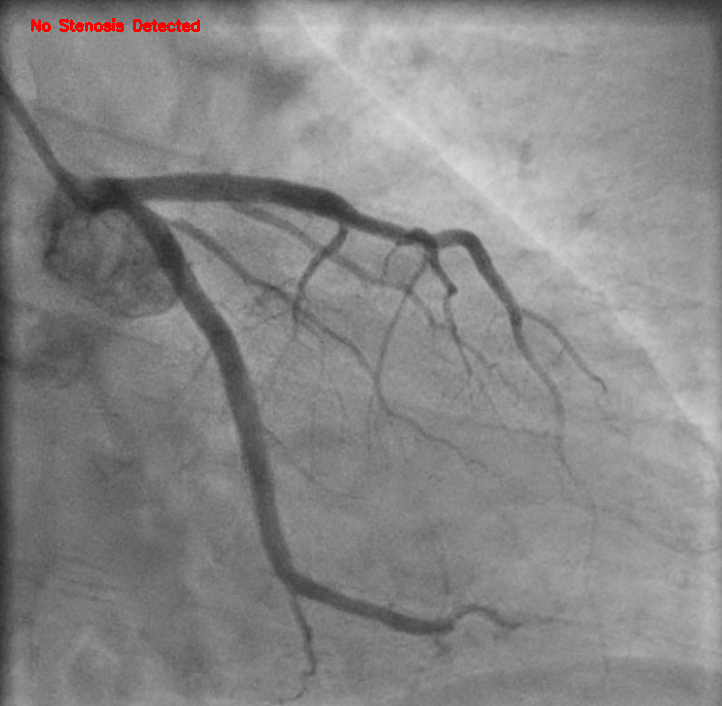

In [ ]:
visualize_detections(image_path, detections)

In [ ]:
import os

def run_combined_model_on_dataset(test_folder, gt_boxes):

    combined_detections = {}

    for filename in os.listdir(test_folder):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            image_path = os.path.join(test_folder, filename)
            detections = detect_stenosis(image_path)  # Run YOLO + EfficientNet

            combined_detections[filename] = detections

    return combined_detections


In [ ]:

test_folder = "/content/drive/MyDrive/Stenosis detection/arcade/stenosis/test/images/"
final_detections = run_combined_model_on_dataset(test_folder, gt)


In [ ]:
import os

# Path to the test images folder
test_folder = "/content/drive/MyDrive/Stenosis detection/arcade/test/images/"
gt_labels = {}
for filename in os.listdir(test_folder):
    if filename.endswith((".png", ".jpg")):
        if filename.startswith("stenosis"):
            gt_labels[filename] = 1  # Stenosis Present
        elif filename.startswith("non_stenosis"):
            gt_labels[filename] = 0  # No Stenosis (Non-Stenotic)

# Print a few samples from the dictionary to verify
print(list(gt_labels.items())[:5])
len(gt_labels)


[('stenosis_10.png', 1), ('stenosis_126.png', 1), ('stenosis_139.png', 1), ('stenosis_135.png', 1), ('stenosis_118.png', 1)]


600

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
test_folder = "/content/drive/MyDrive/Stenosis detection/arcade/test/images/"

predictions = []
true_labels = []

for filename, label in gt_labels.items():
    image_path = test_folder + filename
    pred = 1 if detect_stenosis(image_path) else 0  # If YOLO detects anything, classify as 1

    predictions.append(pred)
    true_labels.append(label)



1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/test/images/stenosis_10.png: 512x512 1 stenosis, 461.4ms
Speed: 2.0ms preprocess, 461.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/test/images/stenosis_126.png: 512x512 1 stenosis, 723.8ms
Speed: 2.6ms preprocess, 723.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/test/images/stenosis_139.png: 512x512 1 stenosis, 456.6ms
Speed: 2.0ms preprocess, 456.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

image 1/1 /content/drive/MyDrive/Stenosis detection/arcade/test/images/stenosis_135.png: 512x512 1 stenosis, 464.1ms
Speed: 1.9ms preprocess, 464.1ms inference, 1.2ms postprocess per image at shape (1, 3, 512

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Compute Metrics
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)


print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, Accuracy: {accuracy:.4f}")

Precision: 1.0000, Recall: 0.8067, F1-score: 0.8930, Accuracy: 0.8067


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(true_labels, predictions))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.89       300

    accuracy                           0.81       300
   macro avg       0.50      0.40      0.45       300
weighted avg       1.00      0.81      0.89       300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
print(f"\nTrue Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")


True Positives (TP): 242
True Negatives (TN): 0
False Positives (FP): 0
False Negatives (FN): 58
